A few spot tests to decide on details for counting bed and shoreline
interactions.

Namely, choose a sinking groups and a rising group

Develop a basic counting for how close they are to the bed and
to shallow water

Pull some trajectories, plot to make sure it all makes sense.

Plot distributions and figure a tolerance or a few tolerances.

In [95]:
from stompy.model.fish_ptm import ptm_tools
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from stompy import utils
from stompy.grid import unstructured_grid
import postproc_dask as post
import six

%matplotlib notebook

In [96]:
six.moves.reload_module(post)

<module 'postproc_dask' from '/home/rusty/src/microplastic_sfbay/postprocess/postproc_dask.py'>

In [90]:
import cfg_v01 
cfg=dict(cfg_v01.cfg)

In [91]:
grp=cfg['ptm_base_dir']+"/chunk00/20171018/Alameda_Creek_down5000_rel20171018_bin.out"

In [93]:
# Hydro timestamps
cfg['hydro_timestamps']=post.load_hydro_timestamps(cfg['sun_paths'])

In [4]:
pbf=ptm_tools.PtmBin(grp)

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
suffix="-v00.nc"
info=xr.open_dataset(grp+suffix)

In [98]:
hyd_i=post.t_to_idx(info.time.values[0],cfg)

In [100]:
six.moves.reload_module(post)
hyd=post.hydro_ds(hyd_i,cfg)

In [102]:
grid=unstructured_grid.UnstructuredGrid.read_ugrid(hyd,dialect='fishptm')

In [32]:
# Time series of distance to bed and watercolumn depth
d_bed=np.full( (info.dims['time'],info.dims['id']), np.nan, np.float32)
h    =np.full( (info.dims['time'],info.dims['id']), np.nan, np.float32)
X    =np.full( (info.dims['time'],info.dims['id'],2), np.nan, np.float64)


In [135]:
info.time.values[0]

numpy.datetime64('2017-10-18T00:00:00.000000000')

INFO:UnstructuredGrid:Recalculating edge to cells


<IPython.core.display.Javascript object>


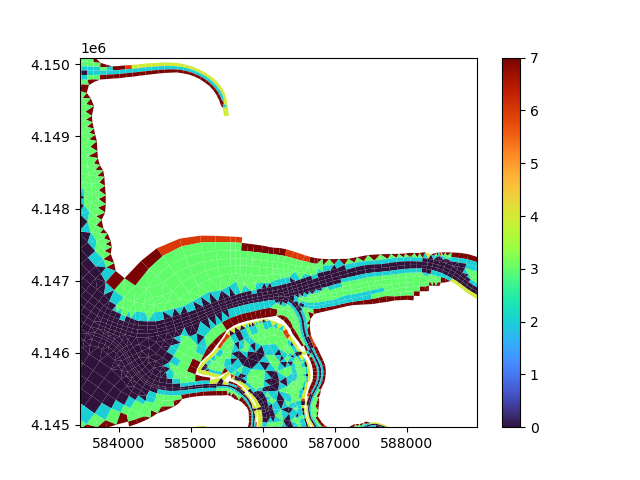

In [147]:
# And dry cells for a given time step            
six.moves.reload_module(post)        
CS=post.CellStatus(cfg=cfg,grid=grid)
CS.fig_status()


In [34]:
for tid,t in utils.progress(enumerate(pbf.time)):
    _,particles=pbf.read_timestep(tid)
    pid=particles['id']-1
    z_part=particles['x'][:,2]
    z_surf=info.z_surf.isel(time=tid,id=pid).values
    cell=info.cell.isel(time=tid,id=pid).values
    z_bed=grid.cells['z_bed'][cell]
    d_bed[tid,pid]=z_part - z_bed
    h[tid,pid]    =z_surf - z_bed
    X[tid,pid] = particles['x'][:,:2]
    
    # And check whether we're adjacent to a boundary or 
    # dry cell
    

<IPython.core.display.Javascript object>


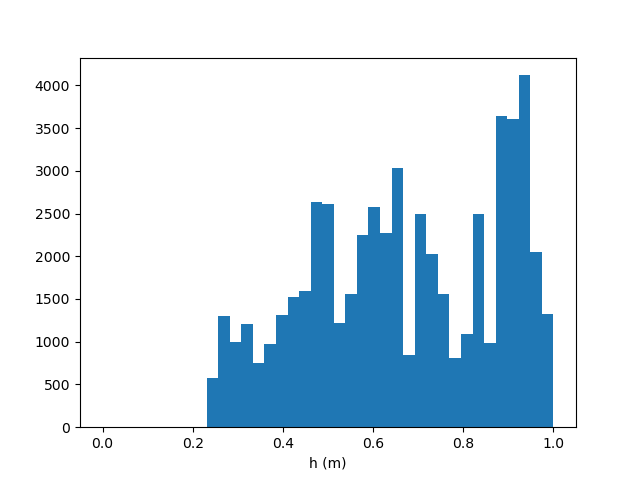

<IPython.core.display.Javascript object>


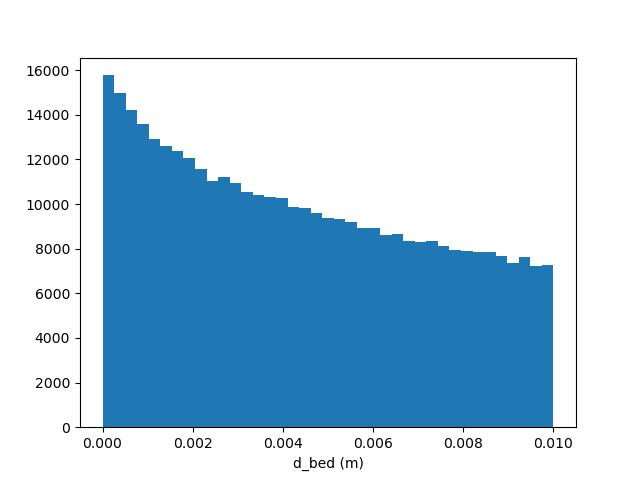

In [28]:
plt.figure()
# h
plt.hist(h[np.isfinite(h)],bins=np.linspace(0,1,40))
plt.xlabel('h (m)')
# d_bed
plt.figure()
plt.hist(d_bed[np.isfinite(d_bed)],bins=np.linspace(0,0.01,40))
plt.xlabel('d_bed (m)')
None

In [ ]:
# Something is weird. No dry cells in the domain?
# min of h is 0.20
# Check the regular average output: same deal.
# I only have original average output for merged021, but the ptm
# hydro looks the same for merged_022 and 021.

# Nothing seems this large in the suntans code.
# suntans.dat for merged022 has minimum_depth=0.1
# also dzsmall=0.1
# sure enough, runs had dzmin_surface=0.25.
# And evaporation is letting a small number of cells fall to 0.20.
# Is there anything in the ctop/cbot that signifies dry? nope. ctop=cbot
# occurs for h anywhere from 0.20 to 1.0.
# Is it enough to then just test for h<=0.25+eps?
# In the code, what is the difference between dzmin_surface
# and DRYCELLHEIGHT?
# When dzmin_surface is larger than DRYCELLHEIGHT (as it was)
# then DRYCELLHEIGHT doesn't come into play.
# ctop/cbot does not tell us anything more about dry cells.
# ctop=cbot for cells with h ranging from 0.2 to 1.0m.

# Since in some cases the shoreline is not well-resolved,
# should also track how often particles in a boundary cell.
# Should it be a boundary cell, a cell adjacent to a dry cell,
# or something else?
# Say you're a buoyant particle, you could get blown to a shoreline,
# but with the stairstepped bed you might have to stop getting blown
# in a particular direction when you hit the wetting front.  So you're
# local cell might still be deep, but you're artificially prevented from
# going into the shore and beaching. In that case I'd want to know that this
# particle was adjacent to a dry cell.
# So at each step, have to load the hydro, mark boundary cells, mark dry
# cells, and cells adjacent to a dry cell. Count how often particles are
# in a dry cell, and how often adjacent to a dry or boundary cell.

<IPython.core.display.Javascript object>


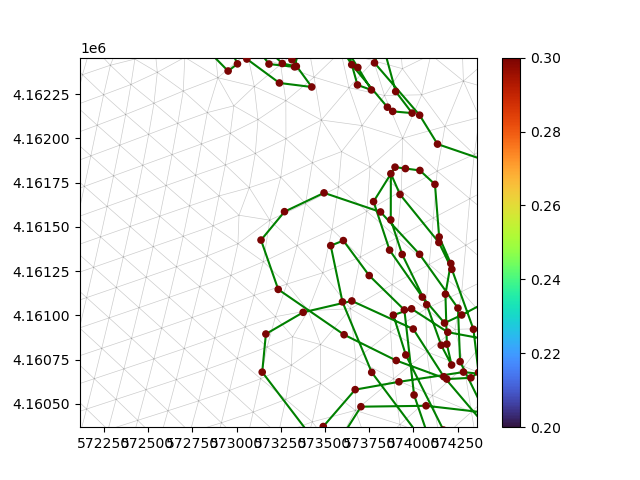

In [43]:
# Follow a few sinking particles, make sure the trajectory seems
# consistent with h and d_bed
# 
fig,ax=plt.subplots()

zoom=(551404.2955731227, 600474.4273861515, 4132843.0835015085, 4178549.536924128)

grid.plot_edges(color='k',lw=0.5,alpha=0.2,ax=ax,clip=zoom)

pid=0
ax.plot(X[:,pid,0],X[:,pid,1],'g-')
scat=ax.scatter(X[:,pid,0],X[:,pid,1],20,h[:,pid],cmap='turbo',zorder=3)
scat.set_clim([0.2,0.3])
plt.axis('tight')
plt.axis('equal')
plt.axis(zoom)
plt.colorbar(scat)

<IPython.core.display.Javascript object>


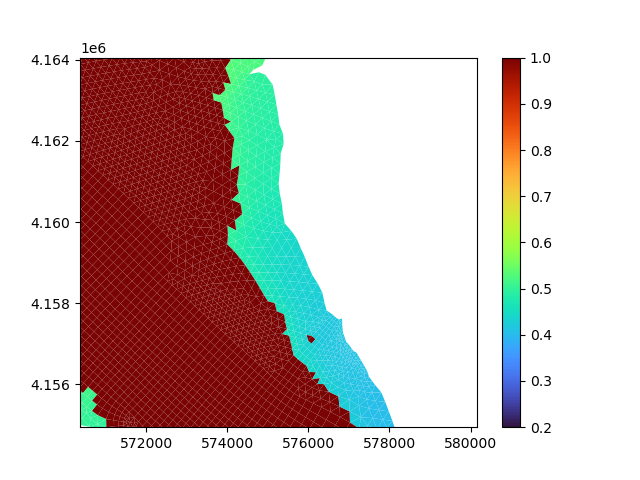

(570371.335389721, 580153.4776669749, 4155852.8332768218, 4163142.1070382604)

In [85]:
# How well is the wetting front resolved?  Do I need
# to record time in boundary cells, too?
ti=4

plt.figure()
h_cell=(hyd['Mesh2_sea_surface_elevation'].isel(nMesh2_data_time=ti)
        + hyd['Mesh2_face_depth']).values
ccoll=grid.plot_cells(values=h_cell,cmap='turbo')
ccoll.set_clim([0.2,1.0])
plt.colorbar(ccoll)
plt.axis('tight')
plt.axis('equal')
plt.axis((570371.335389721, 580153.4776669749, 4155852.8332768218, 4163142.1070382604))

In [52]:
plt.axis()

(570371.335389721, 580153.4776669749, 4155852.8332768218, 4163142.1070382604)